In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir(r'/content/drive/MyDrive/Colab Notebooks/ece1512/ProjectA')  # Change the directory to torchRay-master folder

# Requirements

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import cv2

# Dataset loader

In [ ]:
train_dir = 'hmt_dataset/HMT_train' #you should change to your directory
test_dir = 'hmt_dataset/HMT_test' #you should change to your directory

train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=False)

Found 4514 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


Overrided

# Create Model

In [ ]:
weight_decay = 5e-4
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten?

#model.add(Flatten())
model.add(GlobalAveragePooling2D())
#model.add(Dense(1024, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
#                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(8, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                  

# Training

In [ ]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

In [ ]:
def lr_scheduler(epoch):
    base_ep = 15
    return 1e-3 * (.5 ** (epoch // base_ep))
lr_reduce_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir='log2', write_graph=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, min_delta=0.)

In [ ]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.n // 32,
                    epochs=150,
                    callbacks=[tensorboard_cb],                  
                    shuffle = True,
                    verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/150
 10/141 [=>............................] - ETA: 10:27 - loss: 2.1963 - accuracy: 0.1281

KeyboardInterrupt: ignored

In [ ]:
model.save('HMT.h5')

# Load Model

In [ ]:
model=load_model('/content/drive/MyDrive/Colab Notebooks/ece1512/ProjectA/models/HMT.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  app.launch_new_instance()


Overall Accuracy is 0.8346773982048035


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


accuracy of each class: 

Tumor  :  0.8548387096774194
Stroma  :  0.7580645161290323
Complex  :  0.7741935483870968
Lympho  :  0.8548387096774194
Debris  :  0.6612903225806451
Mucosa  :  0.8225806451612904
Adiopse  :  0.9516129032258065
Empty  :  1.0




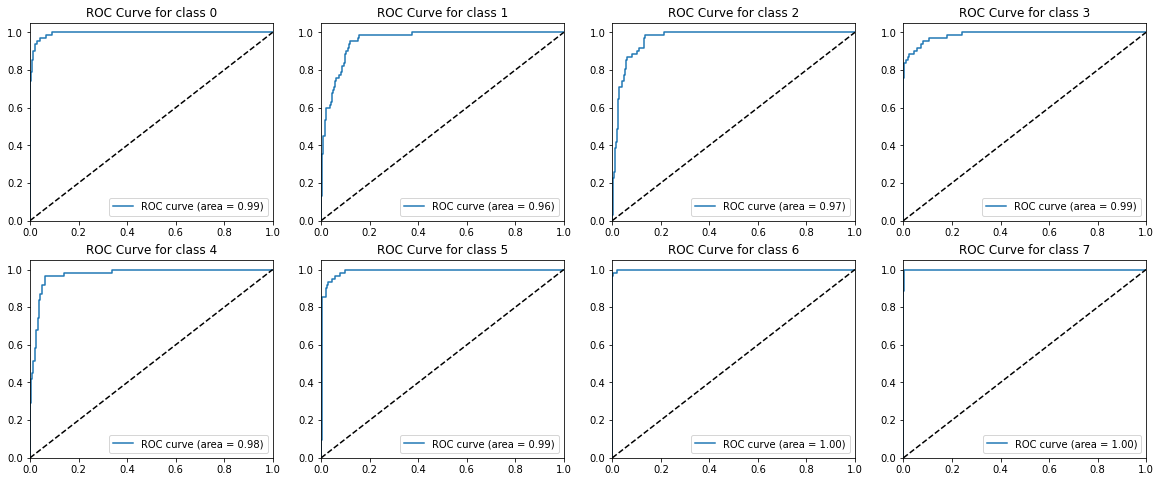

Precision: 0.8346774193548387, Recall: 0.8346774193548387, F1: 0.8346774193548387


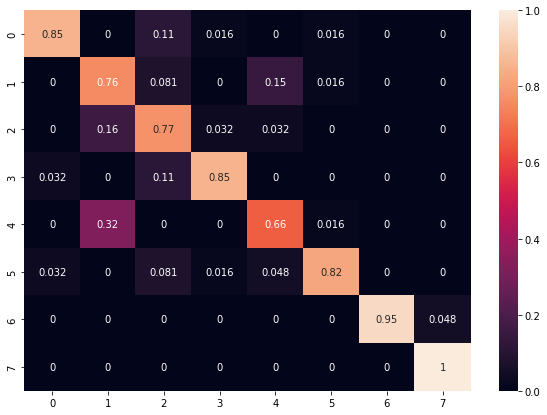

In [ ]:
from matplotlib import test
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
##Task1-Question3.a

#Your code
## show training accuracy and loss
# from tensorboard import notebook
# notebook.list()
# notebook.display(port=6006, height=1000) 

## overall classification accuracy on test set
test_loss, test_acc = model.evaluate_generator(generator=test_generator)
print("Overall Accuracy is", test_acc)

prob = model.predict_generator(test_generator)
y_pred = np.array([np.argmax(x) for x in prob])
y_test = test_generator.classes
cm = confusion_matrix(y_test, y_pred, normalize='true')
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
class_acc = cm.diagonal()
one_hot_y_test = np.zeros((y_test.shape[0], 8))
one_hot_y_test[np.arange(y_test.size),y_test] = 1

print('accuracy of each class: \n')
for i in range(len(classes)):
  print(classes[i], ' : ', class_acc[i])
print('\n')

#ROC and AUC curve
fpr = []
tpr = []
roc_auc = []
for i in range(one_hot_y_test.shape[1]):

  class_fpr, class_tpr, _ = roc_curve(one_hot_y_test[:, i], prob[:, i])
  fpr.append(class_fpr)
  tpr.append(class_tpr)
  roc_auc.append(auc(class_fpr, class_tpr))

plt.figure(figsize=(20,8))
for i in range(one_hot_y_test.shape[1]):
    plt.subplot(2,4,1 + i)
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('ROC Curve for class {}'.format(i))
    plt.legend(loc="lower right")
plt.show()
## normalized confusion matrix
# cm = confusion_matrix(test_label, prediction, normalize='true')
df_cm = pd.DataFrame(cm, index = [i for i in range(one_hot_y_test.shape[1])],
                  columns = [i for i in range(one_hot_y_test.shape[1])])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

## precision recall f1
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')
print("Precision: {}, Recall: {}, F1: {}".format(precision,  recall, f1))

# Explanation

Load the explaier library

In [ ]:
from xai_utils import *

Load a batch of images

In [ ]:
test_generator.reset()

In [ ]:
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']

Predict a single image

In [ ]:
def grad_cam(input_model, image, layer_name):
    cls = np.argmax(input_model.predict(image))
    def normalize(x):
        """Utility function to normalize a tensor by its L2 norm"""
        return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output
    conv_output = input_model.get_layer(layer_name).output
    feedforward1 = keras.models.Model([input_model.input], [conv_output, y_c])
    with tf.GradientTape() as tape:
        ff_results=feedforward1([image])
        all_fmap_masks, predictions = ff_results[0], ff_results[-1]
        loss = predictions[:, cls]
    grads_val = tape.gradient(loss, all_fmap_masks)
    if len(image.shape)==3:
        axis=(0, 1)
    elif len(image.shape)==4:
        axis=(0, 1, 2)
    weights = np.mean(grads_val, axis=axis)
    cam = np.dot(all_fmap_masks[0], weights)
    #print (cam)
    H,W= image.shape[1:3]
    cam = np.maximum(cam, 0)
    #cam = resize(cam, (H, W))
    cam = zoom(cam,H/cam.shape[0])
    #cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

def smooth_grad(input_model, image, n, noise_level):
  cls = np.argmax(input_model.predict(image))
  smooth_grads = np.zeros_like(image)
  std = np.sqrt(noise_level * (np.max(image) - np.min(image)))
  feedforward = keras.models.Model(input_model.input, input_model.output)
  i = 0
  while i < n:
    noise_input = image + np.random.normal(0, std, image.shape)
    noise_input = tf.Variable(noise_input, dtype=tf.float32)
    # noise_input = image
    with tf.GradientTape() as tape:
      preds = feedforward([noise_input])
      noise_label = np.argmax(preds)
      loss = preds[:, cls]
    if noise_label == cls:
      grads = tape.gradient(loss, noise_input)
      smooth_grads += np.abs(grads)
    i += 1
  smooth_grads /= i
  if len(smooth_grads.shape) == 4:
    smooth_grads = np.mean(smooth_grads, axis=3)[0]
  return smooth_grads

In [ ]:
prediction=model(image_batch)
print(image_batch.shape)
print(prediction.shape)

exp = smooth_grad(model, np.expand_dims(image_batch[0], axis=0), 50, 0.1)
exp -= exp.min()
exp /= exp.max()+10e-30

test_generator.reset()
each_cat = []
found = set()
flag = True
while flag:
  image_batch, label_batch = test_generator.next()
  prediction = model(image_batch)
  prediction = np.argmax(prediction, axis=1)
  label_batch = np.argmax(label_batch, axis=1)
  print(prediction)
  print(label_batch)
  for i in range(len(prediction)):
    if len(found) == len(classes):
      flag = False
    if label_batch[i] not in found:
      if prediction[i] == label_batch[i]:
        found.add(label_batch[i])
        each_cat.append(image_batch[i])

each_cat = np.array(each_cat)
print(each_cat.shape)



for i in range(each_cat.shape[0]):
  explanation_map_GradCAM = grad_cam(model, np.expand_dims(each_cat[i], axis=0), 'max_pooling2d_1')
  explanation_map_GradCAM -= explanation_map_GradCAM.min()
  explanation_map_GradCAM /= explanation_map_GradCAM.max()+10e-30

  explanation_smooth_grad = smooth_grad(model, np.expand_dims(each_cat[i], axis=0), 50, 0.05)
  explanation_smooth_grad -= explanation_smooth_grad.min()
  explanation_smooth_grad /= explanation_smooth_grad.max()+10e-30


  plt.figure(figsize=(20,5))

  plt.subplot(1,3,1)
  plt.imshow(each_cat[i])
  plt.axis('off')
  plt.title('Sample image')

  plt.subplot(1,3,2)
  plt.imshow(each_cat[i])
  plt.imshow(explanation_map_GradCAM, cmap='jet', alpha=0.5)
  plt.axis('off')
  plt.title('Explanation map (Grad-CAM)')

  plt.subplot(1,3,3)
  plt.imshow(each_cat[i])
  plt.imshow(explanation_smooth_grad, cmap='jet', alpha=0.5)
  plt.axis('off')
  plt.title('Explanation map (Smooth Grad)')


Output hidden; open in https://colab.research.google.com to view.

## Quantitative evaluation of the explanation algorithm

In [ ]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:,:]
    img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,224,224,3))
    exmap1_thr[0,:,:,0]=img[0,:,:,0]*exmap1_msk
    exmap1_thr[0,:,:,1]=img[0,:,:,1]*exmap1_msk
    exmap1_thr[0,:,:,2]=img[0,:,:,2]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [ ]:
test_generator.reset()
drop_rate = 0.
increase_rate = 0.
for i in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        print(i, index)
        prediction=model(image_batch)
        # explanation_map_GradCAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
        # res = calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_GradCAM, class_index=np.argmax(prediction[index]), frac=0.9)
        explanation_smooth_grad = smooth_grad(model, np.expand_dims(image_batch[index], axis=0), 50, 0.05)
        res = calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_smooth_grad, class_index=np.argmax(prediction[index]), frac=0.9)

        drop_rate += res[0]
        increase_rate += res[1]

drop_rate /= (15*32)
increase_rate /= (15*32)

print(drop_rate, increase_rate)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
4 20
4 21
4 22
4 23
4 24
4 25
4 26
4 27
4 28
4 29
4 30
4 31
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
5 20
5 21
5 22
5 23
5 24
5 25
5 26
5 27
5 28
5 29
5 30
5 31
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
6 17
6 18
6 19
6 20
6 21
